## Phase 1 (a) : Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import time
import sys
import gc
import pickle
from datetime import datetime

from lightgbm import LGBMRegressor

In [2]:
# load data
items = pd.read_csv('data/items.csv')
shops = pd.read_csv('data/shops.csv')
categories = pd.read_csv('data/item_categories.csv')
train = pd.read_csv('data/sales_train_v2.csv')
test  = pd.read_csv('data/test.csv').set_index('ID')

In [3]:
# Check training data
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
# Describe function
round(train.describe(),0)

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935849.0,2935849.0,2935849.0,2935849.0,2935849.0
mean,15.0,33.0,10197.0,891.0,1.0
std,9.0,16.0,6324.0,1730.0,3.0
min,0.0,0.0,0.0,-1.0,-22.0
25%,7.0,22.0,4476.0,249.0,1.0
50%,14.0,31.0,9343.0,399.0,1.0
75%,23.0,47.0,15684.0,999.0,1.0
max,33.0,59.0,22169.0,307980.0,2169.0


We can notice an item_price to be negative. This is actually returned items. We'll keep it for now.

In [5]:
# format date
#print(datetime.strptime('02.01.2013','%d.%m.%Y'))

train['date'] = train['date'].apply(lambda x: datetime.strptime(x,'%d.%m.%Y'))
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


Checking if test has the same number of shops and items as train.

In [6]:
print('Number of distinct items in train: ', train['item_id'].unique().shape[0])
print('Number of distinct items in test: ', test['item_id'].unique().shape[0])

print('Number of distinct shops in train: ', train['shop_id'].unique().shape[0])
print('Number of distinct shops in test: ', test['shop_id'].unique().shape[0])

print('Items in test but not in train:', len(list(set(test['item_id']) - set(test['item_id']).intersection(set(train['item_id'])))))
print('Shops in test but not in train:', len(list(set(test['shop_id']) - set(test['shop_id']).intersection(set(train['shop_id'])))))


Number of distinct items in train:  21807
Number of distinct items in test:  5100
Number of distinct shops in train:  60
Number of distinct shops in test:  42
Items in test but not in train: 363
Shops in test but not in train: 0


So, there are 363 items in test set that is not present in the training set. We have to cater for that later.

Check for missing values.

In [7]:
train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

There is no missing value in the training set.

Plotting Top 5 Most Expensive Item Categories

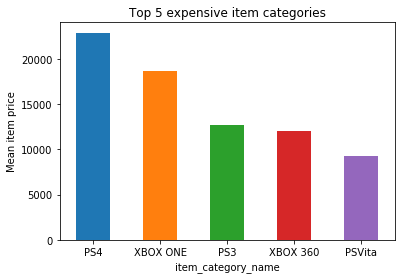

In [8]:
df = train
df = pd.merge(df, items, on='item_id')
df = pd.merge(df, categories, on='item_category_id')
itemPriceMean = df.groupby('item_category_name').item_price.mean()

# Sorting the series with mean item price values in descending order
sortedItemPriceMean = itemPriceMean.sort_values(ascending=False)[:5]

nameList = [x.split(' - ')[1] for x in sortedItemPriceMean.index.tolist()]
srs = sortedItemPriceMean.rename(dict(zip(sortedItemPriceMean.index,nameList)))
srs.plot(kind='bar',rot=0)
plt.ylabel('Mean item price')
plt.title('Top 5 expensive item categories')
plt.show()

Plot the total number of items sold by month.

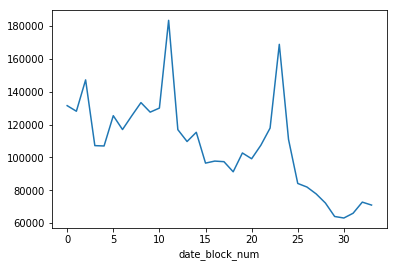

In [9]:
items_sold_by_month = train.groupby('date_block_num')['item_cnt_day'].sum()
items_sold_by_month.plot()

We can see a clear trend and seasonality in the data. There are also peaks in the month of December.

Plot items sold by shops

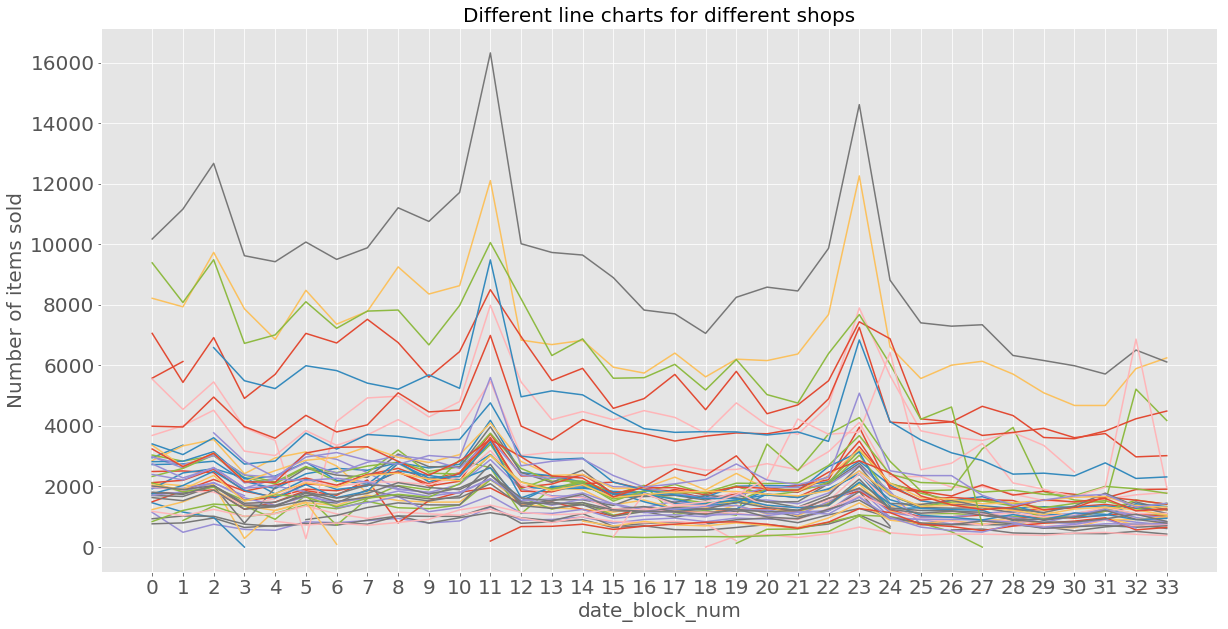

In [10]:
df = pd.merge(df, shops, on='shop_id')
salesByMonthAndShop = df.groupby(['date_block_num','shop_name']).item_cnt_day.sum()

plt.style.use('ggplot')
salesByMonthAndShop.unstack(level=1).plot(kind='line',legend=None,figsize=(20,10),fontsize=20)
plt.xticks(range(0,34))
plt.xlabel('date_block_num',fontsize=20)
plt.ylabel('Number of items sold',fontsize=20)
plt.title('Different line charts for different shops',fontsize=20)
plt.show()

We confirm that there is a surge in the number of items sold in December. 

Check the distribution of number of items sold grouped by month, item and shop 

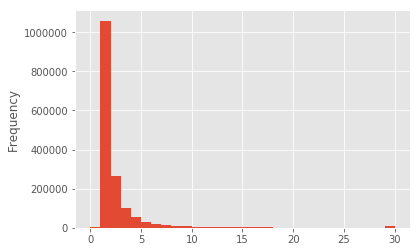

In [11]:
block_item_sold_count = train.groupby(['date_block_num','item_id','shop_id'])['item_cnt_day'].sum()
block_item_sold_count.clip(0,30).plot.hist(bins=30)

We can see that the majority of the item-shop pairs sell less than 5 units on a monthly basis.


# Phase 1 (b): Data Cleaning

#### Check for outliers
Remove outliers with very large item_cnt_day and item_price.

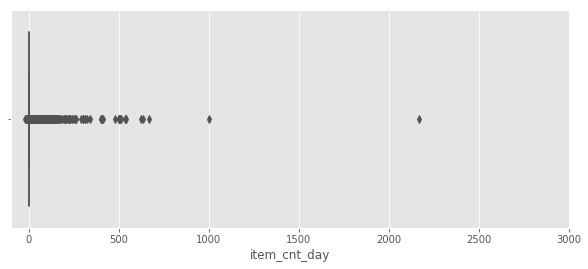

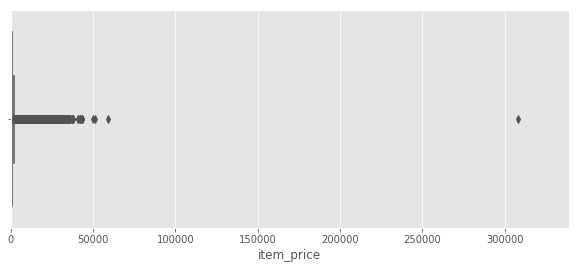

In [12]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

There is one item with price below zero. Fill it with median.

In [13]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

Out of the 60 shops, a few of them are duplicates. They have similar names.
Resolve by updating them with 1 specific shop id.

In [14]:
# shop_id:0   !Якутск Орджоникидзе, 56 фран
# shop_id:57  Якутск Орджоникидзе, 56

# shop_id:1   !Якутск ТЦ "Центральный" фран
# shop_id:58  Якутск ТЦ "Центральный"

# shop_id:10   Жуковский ул. Чкалова 39м?
# shop_id:11   Жуковский ул. Чкалова 39м²

# Resolving all shop_id info as follows:
# shop_id 0 -> 57
# shop_id 1 -> 58
# shop_id 10 -> 11

# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

# Phase 2: Feature Engineering

#### Break down shops name into shop_id and city 

In [15]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_id'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_id']]

#### Break Down Categories into type and subtype

In [16]:
categories['split'] = categories['item_category_name'].str.split('-')
categories['type'] = categories['split'].map(lambda x: x[0].strip())
categories['type_id'] = LabelEncoder().fit_transform(categories['type'])
categories['subtype'] = categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
categories['subtype_id'] = LabelEncoder().fit_transform(categories['subtype'])
categories = categories[['item_category_id','type_id', 'subtype_id']]

#### Dropping Item Name

In [17]:
items.drop(['item_name'], axis=1, inplace=True)

#### Resolving Test and Train Data - Adding new records to the training set to cater for the 363 items that was present only in the test set. For these new records we'll set the item_cnt_month = 0

In [18]:
ts = time.time()
output = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    output.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
output = pd.DataFrame(np.vstack(output), columns=cols)
output['date_block_num'] = output['date_block_num'].astype(np.int8)
output['shop_id'] = output['shop_id'].astype(np.int8)
output['item_id'] = output['item_id'].astype(np.int16)
output.sort_values(cols,inplace=True)
time.time() - ts

28.198116302490234

In [19]:
output.head()

,date_block_num,shop_id,item_id
114910,0,2,19
117150,0,2,27
120623,0,2,28
118316,0,2,29
114602,0,2,32


#### Calculate Revenue

In [20]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

#### Sum shop/item pairs in train set to calculate response aggregate, then limit the response value between 0 and 20.

In [21]:
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

output = pd.merge(output, group, on=cols, how='left')
output['item_cnt_month'] = (output['item_cnt_month']
                                .fillna(0)
                                .clip(0,20)
                                .astype(np.float32))

In [22]:
output.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0


#### Appending test set shop_id and item_id to output

In [23]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
output = pd.concat([output, test], ignore_index=True, keys=cols)
output.fillna(0, inplace=True) # 34 month

#### Generating Features for Shops, Items and Categories (city_id, item_category_id, type_id, subtype_id)

In [24]:
output = pd.merge(output, shops, on=['shop_id'], how='left')
output = pd.merge(output, items, on=['item_id'], how='left')
output = pd.merge(output, categories, on=['item_category_id'], how='left')
output['city_id'] = output['city_id'].astype(np.int8)
output['item_category_id'] = output['item_category_id'].astype(np.int8)
output['type_id'] = output['type_id'].astype(np.int8)
output['subtype_id'] = output['subtype_id'].astype(np.int8)

In [25]:
output.head()

,date_block_num,item_cnt_month,item_id,shop_id,city_id,item_category_id,type_id,subtype_id
0,0,0.0,19,2,0,40,11,4
1,0,1.0,27,2,0,19,5,10
2,0,0.0,28,2,0,30,8,55
3,0,0.0,29,2,0,23,5,16
4,0,0.0,32,2,0,40,11,4


#### Generating Lag Features for item_cnt_month

In [26]:
def response_lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [27]:
ts = time.time()
output = response_lag_feature(output, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts

66.57169604301453

In [28]:
output.head()

,date_block_num,item_cnt_month,item_id,shop_id,city_id,item_category_id,type_id,subtype_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,0.0,19,2,0,40,11,4,NaN,NaN,NaN,NaN,NaN
1,0,1.0,27,2,0,19,5,10,NaN,NaN,NaN,NaN,NaN
2,0,0.0,28,2,0,30,8,55,NaN,NaN,NaN,NaN,NaN
3,0,0.0,29,2,0,23,5,16,NaN,NaN,NaN,NaN,NaN
4,0,0.0,32,2,0,40,11,4,NaN,NaN,NaN,NaN,NaN


#### Generating statistics (mean and standard deviation) of sales of specific groups during the previous year

In [29]:
def generate_statistics(output_, groupby_feats, target, enc_feat, last_periods):
    if not 'date_block_num' in groupby_feats:
        print ('date_block_num must in groupby_feats')
        return output_
    
    group = output_.groupby(groupby_feats)[target].sum().reset_index()
    max_lags = np.max(last_periods)
    for i in range(1,max_lags+1):
        shifted = group[groupby_feats+[target]].copy(deep=True)
        shifted['date_block_num'] += i
        shifted.rename({target:target+'_lag_'+str(i)},axis=1,inplace=True)
        group = group.merge(shifted, on=groupby_feats, how='left')
    group.fillna(0,inplace=True)
    
    for period in last_periods:
        lag_feats = [target+'_lag_'+str(lag) for lag in np.arange(1,period+1)]
        mean = group[lag_feats].sum(axis=1)/float(period)
        mean2 = (group[lag_feats]**2).sum(axis=1)/float(period)
        group[enc_feat+'_avg_sale_prev_'+str(period)] = mean
        group[enc_feat+'_sdev_sale_prev_'+str(period)] = (mean2 - mean**2).apply(np.sqrt)
        group[enc_feat+'_sdev_sale_prev_'+str(period)].replace(np.inf,0,inplace=True)
        # divide by mean, this scales the features for NN
        group[enc_feat+'_avg_sale_prev_'+str(period)] /= group[enc_feat+'_avg_sale_prev_'+str(period)].mean()
        group[enc_feat+'_sdev_sale_prev_'+str(period)] /= group[enc_feat+'_sdev_sale_prev_'+str(period)].mean()
    cols = groupby_feats + [f_ for f_ in group.columns.values if f_.find('_sale_prev_')>=0]
    output = output_.merge(group[cols], on=groupby_feats, how='left')
    return output

In [30]:
ts = time.time()
output = generate_statistics(output, ['date_block_num', 'item_id'], 'item_cnt_month', 'item', [6,12])
output = generate_statistics(output, ['date_block_num', 'shop_id'], 'item_cnt_month', 'shop', [6,12])
output = generate_statistics(output, ['date_block_num', 'item_category_id'], 'item_cnt_month', 'category', [12])
output = generate_statistics(output, ['date_block_num', 'city_id'], 'item_cnt_month', 'city', [12])
output = generate_statistics(output, ['date_block_num', 'type_id'], 'item_cnt_month', 'type', [12])
output = generate_statistics(output, ['date_block_num', 'subtype_id'], 'item_cnt_month', 'subtype', [12])
time.time() - ts

71.44778776168823

In [31]:
output.head()

,date_block_num,item_cnt_month,item_id,shop_id,city_id,item_category_id,type_id,subtype_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,item_avg_sale_prev_6,item_sdev_sale_prev_6,item_avg_sale_prev_12,item_sdev_sale_prev_12,shop_avg_sale_prev_6,shop_sdev_sale_prev_6,shop_avg_sale_prev_12,shop_sdev_sale_prev_12,category_avg_sale_prev_12,category_sdev_sale_prev_12,city_avg_sale_prev_12,city_sdev_sale_prev_12,type_avg_sale_prev_12,type_sdev_sale_prev_12,subtype_avg_sale_prev_12,subtype_sdev_sale_prev_12
0,0,0.0,19,2,0,40,11,4,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1.0,27,2,0,19,5,10,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,28,2,0,30,8,55,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,29,2,0,23,5,16,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,32,2,0,40,11,4,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Generating Lag features

In [32]:
def create_response_lag(output_, groupby_feats, target, enc_feat, lags):
    group = output_.groupby(groupby_feats).agg({target:'mean'})
    group.columns = [enc_feat]
    group.reset_index(inplace=True)
    output = output_.merge(group, on=groupby_feats, how='left')
    output[enc_feat] = output[enc_feat].astype(np.float16)
    output = response_lag_feature(output, lags, enc_feat)
    output.drop(enc_feat, axis=1, inplace=True)
    return output

In [33]:
ts = time.time()
output = create_response_lag(output, ['date_block_num'], 'item_cnt_month', 'date_avg_item_cnt', [1])
output = create_response_lag(output, ['date_block_num', 'item_id'], 'item_cnt_month', 'date_item_avg_item_cnt', [1,2,3,6,12])
output = create_response_lag(output, ['date_block_num', 'shop_id'], 'item_cnt_month', 'date_shop_avg_item_cnt', [1,2,3,6,12])
output = create_response_lag(output, ['date_block_num', 'item_category_id'], 'item_cnt_month', 'date_cat_avg_item_cnt', [1])
output = create_response_lag(output, ['date_block_num', 'shop_id', 'item_category_id'], 'item_cnt_month', 'date_shop_cat_avg_item_cnt', [1])
output = create_response_lag(output, ['date_block_num', 'city_id'], 'item_cnt_month', 'date_city_avg_item_cnt', [1])
output = create_response_lag(output, ['date_block_num', 'item_id', 'city_id'], 'item_cnt_month', 'date_item_city_avg_item_cnt', [1])
time.time() - ts

1465.5021476745605

In [34]:
output.head()

,date_block_num,item_cnt_month,item_id,shop_id,city_id,item_category_id,type_id,subtype_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,item_avg_sale_prev_6,item_sdev_sale_prev_6,item_avg_sale_prev_12,item_sdev_sale_prev_12,shop_avg_sale_prev_6,shop_sdev_sale_prev_6,shop_avg_sale_prev_12,shop_sdev_sale_prev_12,category_avg_sale_prev_12,category_sdev_sale_prev_12,city_avg_sale_prev_12,city_sdev_sale_prev_12,type_avg_sale_prev_12,type_sdev_sale_prev_12,subtype_avg_sale_prev_12,subtype_sdev_sale_prev_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1
0,0,0.0,19,2,0,40,11,4,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1.0,27,2,0,19,5,10,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0.0,28,2,0,30,8,55,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0.0,29,2,0,23,5,16,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0.0,32,2,0,40,11,4,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Generating trend features

Price trend for the last six months.

In [35]:
ts = time.time()
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

output = pd.merge(output, group, on=['item_id'], how='left')
output['item_avg_item_price'] = output['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

output = pd.merge(output, group, on=['date_block_num','item_id'], how='left')
output['date_item_avg_item_price'] = output['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
output = response_lag_feature(output, lags, 'date_item_avg_item_price')

for i in lags:
    output['delta_price_lag_'+str(i)] = \
        (output['date_item_avg_item_price_lag_'+str(i)] - output['item_avg_item_price']) / output['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
output['delta_price_lag'] = output.apply(select_trend, axis=1)
output['delta_price_lag'] = output['delta_price_lag'].astype(np.float16)
output['delta_price_lag'].fillna(0, inplace=True)

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

output.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

814.8658638000488

In [36]:
output.head()

,date_block_num,item_cnt_month,item_id,shop_id,city_id,item_category_id,type_id,subtype_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,item_avg_sale_prev_6,item_sdev_sale_prev_6,item_avg_sale_prev_12,item_sdev_sale_prev_12,shop_avg_sale_prev_6,shop_sdev_sale_prev_6,shop_avg_sale_prev_12,shop_sdev_sale_prev_12,category_avg_sale_prev_12,category_sdev_sale_prev_12,city_avg_sale_prev_12,city_sdev_sale_prev_12,type_avg_sale_prev_12,type_sdev_sale_prev_12,subtype_avg_sale_prev_12,subtype_sdev_sale_prev_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,delta_price_lag
0,0,0.0,19,2,0,40,11,4,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,0,1.0,27,2,0,19,5,10,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,0,0.0,28,2,0,30,8,55,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,0,0.0,29,2,0,23,5,16,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,0,0.0,32,2,0,40,11,4,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


Last month shop revenue trend

In [37]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

output = pd.merge(output, group, on=['date_block_num','shop_id'], how='left')
output['date_shop_revenue'] = output['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

output = pd.merge(output, group, on=['shop_id'], how='left')
output['shop_avg_revenue'] = output['shop_avg_revenue'].astype(np.float32)

output['delta_revenue'] = (output['date_shop_revenue'] - output['shop_avg_revenue']) / output['shop_avg_revenue']
output['delta_revenue'] = output['delta_revenue'].astype(np.float16)

output = response_lag_feature(output, [1], 'delta_revenue')

output.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts

185.60287284851074

#### Adding month and year to final output

In [38]:
output['month'] = output['date_block_num'] % 12
output['year'] = (output['date_block_num'] / 12).astype(np.int8)

In [39]:
output.head()

,date_block_num,item_cnt_month,item_id,shop_id,city_id,item_category_id,type_id,subtype_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,item_avg_sale_prev_6,item_sdev_sale_prev_6,item_avg_sale_prev_12,item_sdev_sale_prev_12,shop_avg_sale_prev_6,shop_sdev_sale_prev_6,shop_avg_sale_prev_12,shop_sdev_sale_prev_12,category_avg_sale_prev_12,category_sdev_sale_prev_12,city_avg_sale_prev_12,city_sdev_sale_prev_12,type_avg_sale_prev_12,type_sdev_sale_prev_12,subtype_avg_sale_prev_12,subtype_sdev_sale_prev_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,year
0,0,0.0,19,2,0,40,11,4,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,0
1,0,1.0,27,2,0,19,5,10,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,0
2,0,0.0,28,2,0,30,8,55,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,0
3,0,0.0,29,2,0,23,5,16,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,0
4,0,0.0,32,2,0,40,11,4,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,0


#### Add month since the last and first sale

In [40]:
#Month since last sale for each shop/item pair.
ts = time.time()
last_sale = pd.DataFrame()
for month in range(1,35):    
    last_month = output.loc[(output['date_block_num']<month)&(output['item_cnt_month']>0)].groupby(['item_id','shop_id'])['date_block_num'].max()
    df = pd.DataFrame({'date_block_num':np.ones([last_month.shape[0],])*month,
                       'item_id': last_month.index.get_level_values(0).values,
                       'shop_id': last_month.index.get_level_values(1).values,
                       'item_shop_prev_sale': last_month.values})
    last_sale = last_sale.append(df)
last_sale['date_block_num'] = last_sale['date_block_num'].astype(np.int8)

output = output.merge(last_sale, on=['date_block_num','item_id','shop_id'], how='left')
time.time() - ts

106.30026626586914

In [41]:
output.head()

,date_block_num,item_cnt_month,item_id,shop_id,city_id,item_category_id,type_id,subtype_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,item_avg_sale_prev_6,item_sdev_sale_prev_6,item_avg_sale_prev_12,item_sdev_sale_prev_12,shop_avg_sale_prev_6,shop_sdev_sale_prev_6,shop_avg_sale_prev_12,shop_sdev_sale_prev_12,category_avg_sale_prev_12,category_sdev_sale_prev_12,city_avg_sale_prev_12,city_sdev_sale_prev_12,type_avg_sale_prev_12,type_sdev_sale_prev_12,subtype_avg_sale_prev_12,subtype_sdev_sale_prev_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,year,item_shop_prev_sale
0,0,0.0,19,2,0,40,11,4,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,0,NaN
1,0,1.0,27,2,0,19,5,10,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,0,NaN
2,0,0.0,28,2,0,30,8,55,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,0,NaN
3,0,0.0,29,2,0,23,5,16,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,0,NaN
4,0,0.0,32,2,0,40,11,4,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,0,NaN


##### Adding month since last sale for each item

In [42]:

ts = time.time()
last_sale = pd.DataFrame()
for month in range(1,35):    
    last_month = output.loc[(output['date_block_num']<month)&(output['item_cnt_month']>0)].groupby('item_id')['date_block_num'].max()
    df = pd.DataFrame({'date_block_num':np.ones([last_month.shape[0],])*month,
                       'item_id': last_month.index.values,
                       'item_prev_sale': last_month.values})
    last_sale = last_sale.append(df)
last_sale['date_block_num'] = last_sale['date_block_num'].astype(np.int8)

output = output.merge(last_sale, on=['date_block_num','item_id'], how='left')
time.time() - ts

70.12910676002502

In [43]:
output.head()

,date_block_num,item_cnt_month,item_id,shop_id,city_id,item_category_id,type_id,subtype_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,item_avg_sale_prev_6,item_sdev_sale_prev_6,item_avg_sale_prev_12,item_sdev_sale_prev_12,shop_avg_sale_prev_6,shop_sdev_sale_prev_6,shop_avg_sale_prev_12,shop_sdev_sale_prev_12,category_avg_sale_prev_12,category_sdev_sale_prev_12,city_avg_sale_prev_12,city_sdev_sale_prev_12,type_avg_sale_prev_12,type_sdev_sale_prev_12,subtype_avg_sale_prev_12,subtype_sdev_sale_prev_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,year,item_shop_prev_sale,item_prev_sale
0,0,0.0,19,2,0,40,11,4,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,0,NaN,NaN
1,0,1.0,27,2,0,19,5,10,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,0,NaN,NaN
2,0,0.0,28,2,0,30,8,55,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,0,NaN,NaN
3,0,0.0,29,2,0,23,5,16,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,0,NaN,NaN
4,0,0.0,32,2,0,40,11,4,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,0,NaN,NaN


#### Months since the first sale for each shop/item pair and for item only.

In [44]:
ts = time.time()
output['item_shop_first_sale'] = output['date_block_num'] - output.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
output['item_first_sale'] = output['date_block_num'] - output.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

376.3184792995453

In [45]:
output.head()

,date_block_num,item_cnt_month,item_id,shop_id,city_id,item_category_id,type_id,subtype_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,item_avg_sale_prev_6,item_sdev_sale_prev_6,item_avg_sale_prev_12,item_sdev_sale_prev_12,shop_avg_sale_prev_6,shop_sdev_sale_prev_6,shop_avg_sale_prev_12,shop_sdev_sale_prev_12,category_avg_sale_prev_12,category_sdev_sale_prev_12,city_avg_sale_prev_12,city_sdev_sale_prev_12,type_avg_sale_prev_12,type_sdev_sale_prev_12,subtype_avg_sale_prev_12,subtype_sdev_sale_prev_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,year,item_shop_prev_sale,item_prev_sale,item_shop_first_sale,item_first_sale
0,0,0.0,19,2,0,40,11,4,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,0,NaN,NaN,0,0
1,0,1.0,27,2,0,19,5,10,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,0,NaN,NaN,0,0
2,0,0.0,28,2,0,30,8,55,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,0,NaN,NaN,0,0
3,0,0.0,29,2,0,23,5,16,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,0,NaN,NaN,0,0
4,0,0.0,32,2,0,40,11,4,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,0,NaN,NaN,0,0


#### Final Features - drop first 12 months since we have a lag value of 12. 

In [46]:
output = output[output.date_block_num > 11]
output.columns

Index(['date_block_num', 'item_cnt_month', 'item_id', 'shop_id', 'city_id',
       'item_category_id', 'type_id', 'subtype_id', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'item_avg_sale_prev_6',
       'item_sdev_sale_prev_6', 'item_avg_sale_prev_12',
       'item_sdev_sale_prev_12', 'shop_avg_sale_prev_6',
       'shop_sdev_sale_prev_6', 'shop_avg_sale_prev_12',
       'shop_sdev_sale_prev_12', 'category_avg_sale_prev_12',
       'category_sdev_sale_prev_12', 'city_avg_sale_prev_12',
       'city_sdev_sale_prev_12', 'type_avg_sale_prev_12',
       'type_sdev_sale_prev_12', 'subtype_avg_sale_prev_12',
       'subtype_sdev_sale_prev_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_

In [47]:
output.head()

,date_block_num,item_cnt_month,item_id,shop_id,city_id,item_category_id,type_id,subtype_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,item_avg_sale_prev_6,item_sdev_sale_prev_6,item_avg_sale_prev_12,item_sdev_sale_prev_12,shop_avg_sale_prev_6,shop_sdev_sale_prev_6,shop_avg_sale_prev_12,shop_sdev_sale_prev_12,category_avg_sale_prev_12,category_sdev_sale_prev_12,city_avg_sale_prev_12,city_sdev_sale_prev_12,type_avg_sale_prev_12,type_sdev_sale_prev_12,subtype_avg_sale_prev_12,subtype_sdev_sale_prev_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,year,item_shop_prev_sale,item_prev_sale,item_shop_first_sale,item_first_sale
4488710,12,0.0,27,2,0,19,5,10,0.0,0.0,0.0,0.0,1.0,0.234612,0.206960,0.287726,0.174351,0.472628,0.386724,0.467025,0.333101,7.231568,3.821764,0.279986,0.204503,3.601609,2.337632,6.483728,3.721334,0.411377,0.086975,0.044434,0.130493,0.065247,0.155518,0.148071,0.100647,0.08905,0.096008,0.141235,1.082031,0.955566,0.148071,0.0,-0.282715,1.211914,0,1,0.0,11.0,12,12
4488711,12,0.0,30,2,0,40,11,4,0.0,0.0,0.0,0.0,NaN,2.622134,1.578323,10.973563,15.808992,0.472628,0.386724,0.467025,0.333101,19.195847,6.327306,0.279986,0.204503,6.746505,1.869427,15.236700,5.070994,0.411377,1.021484,1.022461,0.521973,0.891113,NaN,0.148071,0.100647,0.08905,0.096008,NaN,0.291504,0.046234,0.148071,0.0,-0.483398,1.211914,0,1,5.0,11.0,11,11
4488712,12,0.0,31,2,0,37,11,1,0.0,0.0,0.0,0.0,NaN,1.863095,0.529975,7.840543,13.207257,0.472628,0.386724,0.467025,0.333101,5.288033,2.249199,0.279986,0.204503,6.746505,1.869427,5.019017,1.996143,0.411377,0.543457,0.600098,0.543457,0.304443,NaN,0.148071,0.100647,0.08905,0.096008,NaN,0.232788,0.059448,0.148071,0.0,-0.137451,1.211914,0,1,3.0,11.0,11,11
4488713,12,1.0,32,2,0,40,11,4,0.0,0.0,0.0,0.0,0.0,6.155114,1.452245,10.502011,5.571384,0.472628,0.386724,0.467025,0.333101,19.195847,6.327306,0.279986,0.204503,6.746505,1.869427,15.236700,5.070994,0.411377,1.934570,1.799805,1.260742,1.891602,5.378906,0.148071,0.100647,0.08905,0.096008,0.141235,0.291504,0.046234,0.148071,0.0,-0.407227,1.211914,0,1,NaN,11.0,12,12
4488714,12,1.0,33,2,0,37,11,1,1.0,2.0,0.0,0.0,1.0,2.953351,1.202052,3.340822,1.292930,0.472628,0.386724,0.467025,0.333101,5.288033,2.249199,0.279986,0.204503,6.746505,1.869427,5.019017,1.996143,0.411377,0.913086,0.333252,0.717285,1.000000,1.355469,0.148071,0.100647,0.08905,0.096008,0.141235,0.232788,0.059448,0.148071,1.0,-0.225464,1.211914,0,1,11.0,11.0,12,12


In [48]:
output.to_pickle('features.pkl')
del output
del group
del items
del shops
del categories
del train
# leave test for submission
gc.collect();

# Phase 3: Clustering

In [21]:
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
from sklearn.decomposition import PCA

In [22]:
data = pd.read_pickle('features.pkl')
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_id',
    'item_category_id',
    'type_id','subtype_id',
    'item_cnt_month_lag_1','item_cnt_month_lag_2','item_cnt_month_lag_3','item_cnt_month_lag_6','item_cnt_month_lag_12',
    'item_avg_sale_prev_6', 'item_sdev_sale_prev_6',
    'item_avg_sale_prev_12', 'item_sdev_sale_prev_12',
    'shop_avg_sale_prev_6', 'shop_sdev_sale_prev_6',
    'shop_avg_sale_prev_12', 'shop_sdev_sale_prev_12',
    'category_avg_sale_prev_12', 'category_sdev_sale_prev_12',
    'city_avg_sale_prev_12', 'city_sdev_sale_prev_12',
    'type_avg_sale_prev_12', 'type_sdev_sale_prev_12',
    'subtype_avg_sale_prev_12', 'subtype_sdev_sale_prev_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1','date_item_avg_item_cnt_lag_2','date_item_avg_item_cnt_lag_3','date_item_avg_item_cnt_lag_6','date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1','date_shop_avg_item_cnt_lag_2','date_shop_avg_item_cnt_lag_3','date_shop_avg_item_cnt_lag_6','date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month','year',
    'item_shop_prev_sale','item_prev_sale',
    'item_shop_first_sale','item_first_sale',
]]

categorical_features = ['shop_id','city_id','item_category_id','type_id','subtype_id']

In [56]:
data.isnull().mean()

date_block_num                       0.000000
shop_id                              0.000000
item_cnt_month                       0.000000
city_id                              0.000000
item_category_id                     0.000000
type_id                              0.000000
subtype_id                           0.000000
item_cnt_month_lag_1                 0.210534
item_cnt_month_lag_2                 0.241724
item_cnt_month_lag_3                 0.272399
item_cnt_month_lag_6                 0.358844
item_cnt_month_lag_12                0.527127
item_avg_sale_prev_6                 0.000000
item_sdev_sale_prev_6                0.000000
item_avg_sale_prev_12                0.000000
item_sdev_sale_prev_12               0.000000
shop_avg_sale_prev_6                 0.000000
shop_sdev_sale_prev_6                0.000000
shop_avg_sale_prev_12                0.000000
shop_sdev_sale_prev_12               0.000000
category_avg_sale_prev_12            0.000000
category_sdev_sale_prev_12        

#### Selecting only a susbet of columns from the original data for clustering purpose:

In [23]:
df2 = data[['date_block_num', 'item_id', 'item_cnt_month', 'shop_id', 
           'city_id', 'item_category_id', 'type_id', 'subtype_id', 
           'item_avg_sale_prev_6', 'item_sdev_sale_prev_6', 
            'item_avg_sale_prev_12', 'item_sdev_sale_prev_12', 
            'shop_avg_sale_prev_6', 'shop_sdev_sale_prev_6',
            'shop_avg_sale_prev_12', 'shop_sdev_sale_prev_12', 
            #'category_avg_sale_prev_12', 'category_sdev_sale_prev_12',
            #'city_avg_sale_prev_12', 'city_sdev_sale_prev_12',
            #'type_avg_sale_prev_12', 'type_sdev_sale_prev_12',
            #'subtype_avg_sale_prev_12', 'subtype_sdev_sale_prev_12',
           ]]

In [24]:
x = df2.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df3 = pd.DataFrame(x_scaled, columns=df2.columns)

In [25]:
df3.head()

,date_block_num,item_id,item_cnt_month,shop_id,city_id,item_category_id,type_id,subtype_id,item_avg_sale_prev_6,item_sdev_sale_prev_6,item_avg_sale_prev_12,item_sdev_sale_prev_12,shop_avg_sale_prev_6,shop_sdev_sale_prev_6,shop_avg_sale_prev_12,shop_sdev_sale_prev_12
0,0.0,0.001218,0.00,0.0,0.0,0.228916,0.263158,0.156250,0.003006,0.004203,0.003237,0.004808,0.095181,0.08078,0.08752,0.115081
1,0.0,0.001353,0.00,0.0,0.0,0.481928,0.578947,0.062500,0.033593,0.032057,0.123471,0.435970,0.095181,0.08078,0.08752,0.115081
2,0.0,0.001398,0.00,0.0,0.0,0.445783,0.578947,0.015625,0.023868,0.010764,0.088219,0.364221,0.095181,0.08078,0.08752,0.115081
3,0.0,0.001443,0.05,0.0,0.0,0.481928,0.578947,0.062500,0.078854,0.029496,0.118165,0.153644,0.095181,0.08078,0.08752,0.115081
4,0.0,0.001489,0.05,0.0,0.0,0.445783,0.578947,0.015625,0.037836,0.024414,0.037590,0.035656,0.095181,0.08078,0.08752,0.115081


In [24]:
#DBSCAN
#db = DBSCAN(eps=0.03, min_samples=50).fit(df3)
#labels = db.labels_
#np.unique(db.labels_)

#### Clustering using K-means with K=5.

In [26]:
from sklearn.cluster import KMeans
k = 5
kmeans = KMeans(n_clusters=k)
kmeans.fit(df3)
labels = kmeans.predict(df3)

In [27]:
np.unique(labels)

array([0, 1, 2, 3, 4])

In [55]:
submit = pd.DataFrame()
for i in range(k):
    #i = 0
    dataCl = data[labels==i]
    # Train
    X_train = dataCl[dataCl.date_block_num < 33].drop(['item_cnt_month'], axis=1)
    Y_train = dataCl[dataCl.date_block_num < 33]['item_cnt_month']

    # Validation
    X_valid = dataCl[dataCl.date_block_num == 33].drop(['item_cnt_month'], axis=1)
    Y_valid = dataCl[dataCl.date_block_num == 33]['item_cnt_month']

    # Test
    X_test = dataCl[dataCl.date_block_num == 34].drop(['item_cnt_month'], axis=1)

    #print(len(X_train), len(X_valid), len(X_test))

    
    GBM_model = LGBMRegressor(
        max_depth = 8,
        n_estimators = 1000,
        colsample_bytree=0.7,
        min_child_weight = 300,
        reg_alpha = 0.1,
        reg_lambda = 1,
        random_state = 42,
        )
    
    GBM_model.fit(
        X_train, 
        Y_train, 
        eval_metric="rmse", 
        eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
        verbose=10, 
        early_stopping_rounds = 40,
        categorical_feature = categorical_features) 
    
    Y_test = GBM_model.predict(X_test).clip(0, 20)
    
    
    GBM_submission = pd.DataFrame({
    "shop_id": X_test['shop_id'],
    "item_id": X_test['item_id'],
    "item_cnt_month": Y_test
    })
    
    submit = submit.append(GBM_submission)
    



c:\users\bhuvan\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['city_id', 'item_category_id', 'shop_id', 'subtype_id', 'type_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 40 rounds
[10]	training's rmse: 0.904297	training's l2: 0.817754	valid_1's rmse: 0.790974	valid_1's l2: 0.625639
[20]	training's rmse: 0.829483	training's l2: 0.688042	valid_1's rmse: 0.74057	valid_1's l2: 0.548443
[30]	training's rmse: 0.80491	training's l2: 0.64788	valid_1's rmse: 0.728459	valid_1's l2: 0.530653
[40]	training's rmse: 0.793333	training's l2: 0.629378	valid_1's rmse: 0.724793	valid_1's l2: 0.525324
[50]	training's rmse: 0.785055	training's l2: 0.616311	valid_1's rmse: 0.722652	valid_1's l2: 0.522226
[60]	training's rmse: 0.778867	training's l2: 0.606634	valid_1's rmse: 0.722169	valid_1's l2: 0.521528
[70]	training's rmse: 0.771699	training's l2: 0.59552	valid_1's rmse: 0.722788	valid_1's l2: 0.522422
[80]	training's rmse: 0.766701	training's l2: 0.58783	valid_1's rmse: 0.720832	valid_1's l2: 0.519598
[90]	training's rmse: 0.762351	training's l2: 0.581179	valid_1's rmse: 0.721121	valid_1's l2: 0.520015
[100]	training's 

c:\users\bhuvan\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['city_id', 'item_category_id', 'shop_id', 'subtype_id', 'type_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 40 rounds
[10]	training's rmse: 0.917945	training's l2: 0.842623	valid_1's rmse: 1.1019	valid_1's l2: 1.21418
[20]	training's rmse: 0.838829	training's l2: 0.703635	valid_1's rmse: 1.05795	valid_1's l2: 1.11925
[30]	training's rmse: 0.813068	training's l2: 0.66108	valid_1's rmse: 1.05268	valid_1's l2: 1.10814
[40]	training's rmse: 0.800525	training's l2: 0.64084	valid_1's rmse: 1.05111	valid_1's l2: 1.10482
[50]	training's rmse: 0.79232	training's l2: 0.62777	valid_1's rmse: 1.05337	valid_1's l2: 1.10958
[60]	training's rmse: 0.785948	training's l2: 0.617715	valid_1's rmse: 1.05348	valid_1's l2: 1.10981
[70]	training's rmse: 0.779087	training's l2: 0.606977	valid_1's rmse: 1.05446	valid_1's l2: 1.11189
Early stopping, best iteration is:
[37]	training's rmse: 0.803865	training's l2: 0.646198	valid_1's rmse: 1.04887	valid_1's l2: 1.10013


c:\users\bhuvan\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['city_id', 'item_category_id', 'shop_id', 'subtype_id', 'type_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 40 rounds
[10]	training's rmse: 1.56046	training's l2: 2.43503	valid_1's rmse: 1.67101	valid_1's l2: 2.79229
[20]	training's rmse: 1.44941	training's l2: 2.10078	valid_1's rmse: 1.58778	valid_1's l2: 2.52104
[30]	training's rmse: 1.41445	training's l2: 2.00066	valid_1's rmse: 1.56602	valid_1's l2: 2.45241
[40]	training's rmse: 1.39804	training's l2: 1.95453	valid_1's rmse: 1.55966	valid_1's l2: 2.43253
[50]	training's rmse: 1.38729	training's l2: 1.92457	valid_1's rmse: 1.55474	valid_1's l2: 2.41721
[60]	training's rmse: 1.37951	training's l2: 1.90306	valid_1's rmse: 1.552	valid_1's l2: 2.40871
[70]	training's rmse: 1.37284	training's l2: 1.8847	valid_1's rmse: 1.55065	valid_1's l2: 2.40451
[80]	training's rmse: 1.36789	training's l2: 1.87112	valid_1's rmse: 1.54964	valid_1's l2: 2.40139
[90]	training's rmse: 1.36261	training's l2: 1.85671	valid_1's rmse: 1.54686	valid_1's l2: 2.39277
[100]	training's rmse: 1.35857	training's l2: 1.845

c:\users\bhuvan\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['city_id', 'item_category_id', 'shop_id', 'subtype_id', 'type_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 40 rounds
[10]	training's rmse: 0.699642	training's l2: 0.489499	valid_1's rmse: 0.846074	valid_1's l2: 0.715841
[20]	training's rmse: 0.660668	training's l2: 0.436482	valid_1's rmse: 0.826482	valid_1's l2: 0.683072
[30]	training's rmse: 0.646332	training's l2: 0.417745	valid_1's rmse: 0.82864	valid_1's l2: 0.686644
[40]	training's rmse: 0.639782	training's l2: 0.40932	valid_1's rmse: 0.830139	valid_1's l2: 0.68913
[50]	training's rmse: 0.634285	training's l2: 0.402318	valid_1's rmse: 0.835491	valid_1's l2: 0.698046
[60]	training's rmse: 0.630815	training's l2: 0.397927	valid_1's rmse: 0.83685	valid_1's l2: 0.700318
Early stopping, best iteration is:
[21]	training's rmse: 0.658442	training's l2: 0.433546	valid_1's rmse: 0.825347	valid_1's l2: 0.681198


c:\users\bhuvan\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['city_id', 'item_category_id', 'shop_id', 'subtype_id', 'type_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 40 rounds
[10]	training's rmse: 0.697951	training's l2: 0.487136	valid_1's rmse: 0.728888	valid_1's l2: 0.531278
[20]	training's rmse: 0.658899	training's l2: 0.434148	valid_1's rmse: 0.71295	valid_1's l2: 0.508297
[30]	training's rmse: 0.643603	training's l2: 0.414225	valid_1's rmse: 0.712876	valid_1's l2: 0.508192
[40]	training's rmse: 0.635137	training's l2: 0.403399	valid_1's rmse: 0.714917	valid_1's l2: 0.511107
[50]	training's rmse: 0.629826	training's l2: 0.396681	valid_1's rmse: 0.719858	valid_1's l2: 0.518195
[60]	training's rmse: 0.625001	training's l2: 0.390626	valid_1's rmse: 0.720631	valid_1's l2: 0.519308
Early stopping, best iteration is:
[24]	training's rmse: 0.650777	training's l2: 0.423511	valid_1's rmse: 0.711666	valid_1's l2: 0.506468


In [56]:
len(submit)

214200

In [61]:
test  = pd.read_csv('data/test.csv')

In [62]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [94]:
submission = pd.merge(test, submit, on=['shop_id', 'item_id'], how='left').drop(['item_id', 'shop_id'], axis=1).sort_values('ID')

In [95]:
submission.head()

,ID,item_cnt_month
0,0,0.437545
1,1,0.423129
2,2,0.654482
3,3,0.392520
4,4,1.646601


In [106]:
submission = submission.fillna(0)

In [107]:
submission.isna().mean()

ID                0.0
item_cnt_month    0.0
dtype: float64

In [108]:
submission.to_csv('kmeans_gbm_submission.csv', index=False)

In [109]:
data[data['shop_id']==10]

,date_block_num,shop_id,item_id,item_cnt_month,city_id,item_category_id,type_id,subtype_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,item_avg_sale_prev_6,item_sdev_sale_prev_6,item_avg_sale_prev_12,item_sdev_sale_prev_12,shop_avg_sale_prev_6,shop_sdev_sale_prev_6,shop_avg_sale_prev_12,shop_sdev_sale_prev_12,category_avg_sale_prev_12,category_sdev_sale_prev_12,city_avg_sale_prev_12,city_sdev_sale_prev_12,type_avg_sale_prev_12,type_sdev_sale_prev_12,subtype_avg_sale_prev_12,subtype_sdev_sale_prev_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,delta_price_lag,month,year,item_shop_prev_sale,item_prev_sale,item_shop_first_sale,item_first_sale


In [110]:
test[test['shop_id']==10]

,ID,shop_id,item_id
30600,30600,10,5037
30601,30601,10,5320
30602,30602,10,5233
30603,30603,10,5232
30604,30604,10,5268
30605,30605,10,5039
30606,30606,10,5041
30607,30607,10,5046
30608,30608,10,5319
30609,30609,10,5003


# Phase 4 (a): Time Series Model - ARIMAX

# Phase 4 (b): Standard Model - GBM Regressor

#### Read Data from Pickle file

In [91]:
data = pd.read_pickle(r'C:\Users\Veekesh\data\output\features.pkl')
data = data[[
    'date_block_num',
    'shop_id',
    #'item_id',
    'item_cnt_month',
    'city_id',
    'item_category_id',
    'type_id','subtype_id',
    'item_cnt_month_lag_1','item_cnt_month_lag_2','item_cnt_month_lag_3','item_cnt_month_lag_6','item_cnt_month_lag_12',
    'item_avg_sale_prev_6', 'item_sdev_sale_prev_6',
    'item_avg_sale_prev_12', 'item_sdev_sale_prev_12',
    'shop_avg_sale_prev_6', 'shop_sdev_sale_prev_6',
    'shop_avg_sale_prev_12', 'shop_sdev_sale_prev_12',
    'category_avg_sale_prev_12', 'category_sdev_sale_prev_12',
    'city_avg_sale_prev_12', 'city_sdev_sale_prev_12',
    'type_avg_sale_prev_12', 'type_sdev_sale_prev_12',
    'subtype_avg_sale_prev_12', 'subtype_sdev_sale_prev_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1','date_item_avg_item_cnt_lag_2','date_item_avg_item_cnt_lag_3','date_item_avg_item_cnt_lag_6','date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1','date_shop_avg_item_cnt_lag_2','date_shop_avg_item_cnt_lag_3','date_shop_avg_item_cnt_lag_6','date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month','year',
    'item_shop_prev_sale','item_prev_sale',
    'item_shop_first_sale','item_first_sale',
]]

categorical_features = ['shop_id','city_id','item_category_id','type_id','subtype_id']

#### Select Train, Validation and Test  

In [92]:
# Train
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']

# Validation
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']

# Test
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

# del data
# gc.collect();

#### Training with GBM Regressor

In [93]:
ts = time.time()

GBM_model = LGBMRegressor(
    max_depth = 8,
    n_estimators = 1000,
    colsample_bytree=0.7,
    min_child_weight = 300,
    reg_alpha = 0.1,
    reg_lambda = 1,
    random_state = 42,
)

GBM_model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=10, 
    early_stopping_rounds = 40,
    categorical_feature = categorical_features) 

time.time() - ts

C:\Users\Veekesh\Anaconda3\lib\site-packages\lightgbm\basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['city_id', 'item_category_id', 'shop_id', 'subtype_id', 'type_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\Veekesh\Anaconda3\lib\site-packages\lightgbm\basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['city_id', 'item_category_id', 'shop_id', 'subtype_id', 'type_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 40 rounds
[10]	training's rmse: 0.914915	training's l2: 0.837069	valid_1's rmse: 0.938257	valid_1's l2: 0.880326
[20]	training's rmse: 0.854046	training's l2: 0.729395	valid_1's rmse: 0.900808	valid_1's l2: 0.811455
[30]	training's rmse: 0.833372	training's l2: 0.694509	valid_1's rmse: 0.893426	valid_1's l2: 0.79821
[40]	training's rmse: 0.823877	training's l2: 0.678774	valid_1's rmse: 0.891299	valid_1's l2: 0.794414
[50]	training's rmse: 0.817065	training's l2: 0.667596	valid_1's rmse: 0.891912	valid_1's l2: 0.795507
[60]	training's rmse: 0.81235	training's l2: 0.659913	valid_1's rmse: 0.890982	valid_1's l2: 0.79385
[70]	training's rmse: 0.808223	training's l2: 0.653224	valid_1's rmse: 0.892136	valid_1's l2: 0.795906
[80]	training's rmse: 0.804514	training's l2: 0.647243	valid_1's rmse: 0.892472	valid_1's l2: 0.796506
[90]	training's rmse: 0.80169	training's l2: 0.642707	valid_1's rmse: 0.892535	valid_1's l2: 0.796619
[100]	training's

30.635566473007202

#### Model Prediction

In [94]:
Y_pred = GBM_model.predict(X_valid).clip(0, 20)
Y_test = GBM_model.predict(X_test).clip(0, 20)

X_train_level2 = pd.DataFrame({
    "ID": np.arange(Y_pred.shape[0]), 
    "item_cnt_month": Y_pred
})
X_train_level2.to_csv(r'C:\Users\Veekesh\data\output\lgb_valid.csv', index=False)

#### Generate Output File for Submission on Kaggle

In [95]:
GBM_submission = pd.DataFrame({
    "ID": np.arange(Y_test.shape[0]), 
    "item_cnt_month": Y_test
})
GBM_submission.to_csv(r'C:\Users\Veekesh\data\output\gbm_submission.csv', index=False)

# Phase 5 - Train and Test of Models